In [4]:
from transformers import AutoTokenizer
from IPython.display import HTML
import random
import torch

from cot_probing.vis import visualize_tokens_html

# model = AutoModelForCausalLM.from_pretrained("google/gemma-2-2b")
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b")
text = "###\n\nWhat is going oooonnn???\nIdk."
tokens = tokenizer.encode(text)
display(
    HTML(
        visualize_tokens_html(
            tokens,
            tokenizer,
            [2 * (random.random() - 0.5) for _ in tokens],
            values_scale=1.0,
        )
    )
)

In [2]:
from cot_probing.activations import Activations
import pickle

with open("../hf_results/activations_google--gemma-2-2b_snarks_S0_N151.pkl", "rb") as f:
    activations = pickle.load(f)
print(activations.layers)
with open("../results/eval_google--gemma-2-2b_snarks_S0_N151.pkl", "rb") as f:
    eval_results = pickle.load(f)
print(eval_results)
eval_results.questions[0]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
EvalResults(model_name=google/gemma-2-2b, task_name=snarks, seed=0, num_samples=151, 73 questions)


EvalQuestion(3281 tokens, locs keys = ['response'], is_correct=False, answer_char=A)

In [32]:
correct_idxs = []
incorrect_idxs = []
correct_mean_acts = []
incorrect_mean_acts = []
for q_idx, q in enumerate(eval_results.questions):
    # shape: (num_layers, num_locs, d_model)
    acts = activations.activations_by_question[q_idx].activations
    acts_mean = acts.mean(dim=1)
    if q.is_correct:
        correct_idxs.append(q_idx)
        correct_mean_acts.append(acts_mean)
    else:
        incorrect_idxs.append(q_idx)
        incorrect_mean_acts.append(acts_mean)
print(f"Correct: {correct_idxs}")
print(f"Incorrect: {incorrect_idxs}")
# correct_acts_mean = torch.mean(torch.stack(correct_mean_acts), dim=0)
incorrect_acts_mean = torch.mean(torch.stack(incorrect_mean_acts), dim=0)
probes = []
for i in range(len(incorrect_mean_acts)):
    # leave one out correct mean acts
    loo_cma = correct_mean_acts[:i] + correct_mean_acts[i + 1 :]
    correct_acts_mean = torch.mean(torch.stack(loo_cma), dim=0)
    probe = correct_acts_mean - incorrect_acts_mean
    probes.append(probe)

Correct: [3, 4, 51, 54, 57, 62, 66]
Incorrect: [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 52, 53, 55, 56, 58, 59, 60, 61, 63, 64, 65, 67, 68, 69, 70, 71, 72]


In [35]:
from fancy_einsum import einsum

CORR_Q_LOO = 1
probe_acts_by_layer_by_q = []
for q_idx in range(len(eval_results.questions)):
    acts = activations.activations_by_question[q_idx].activations
    probe_acts = einsum(
        "layers locs model, layers model -> layers locs", acts, probes[CORR_Q_LOO]
    )
    probe_acts_by_layer_by_q.append(probe_acts)

Layer 0


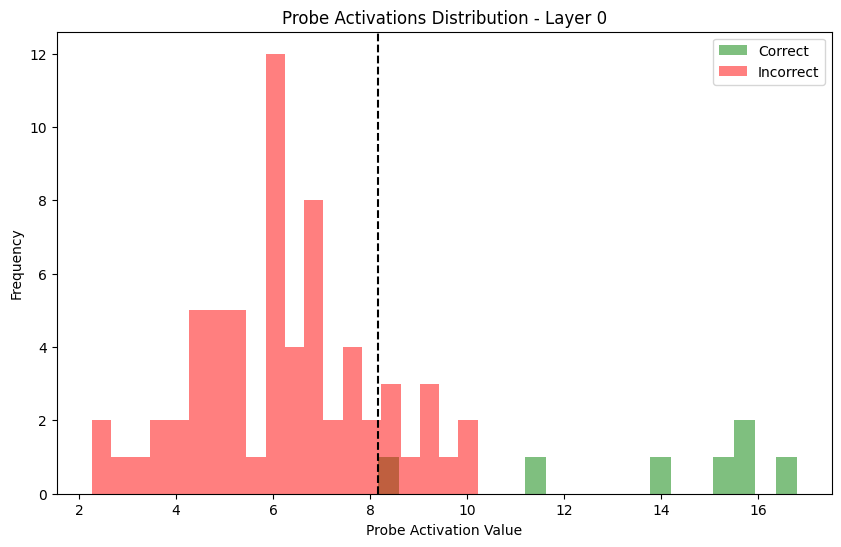

Layer 1


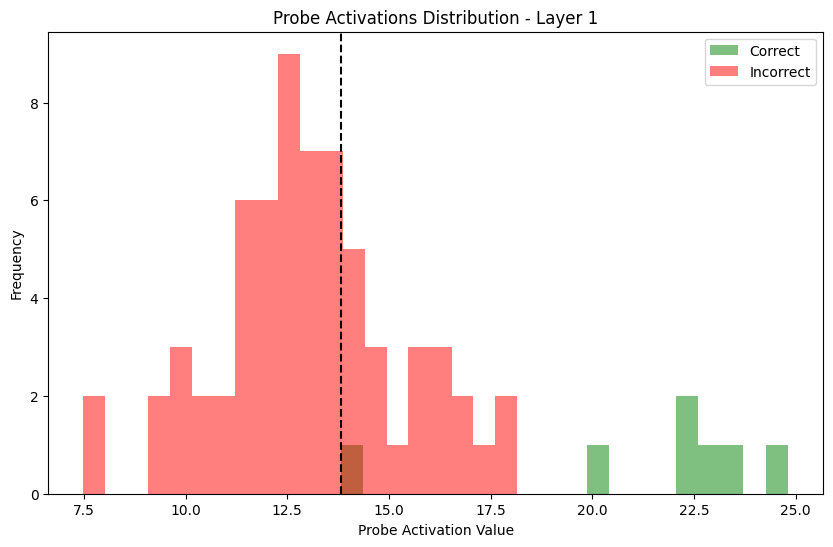

Layer 2


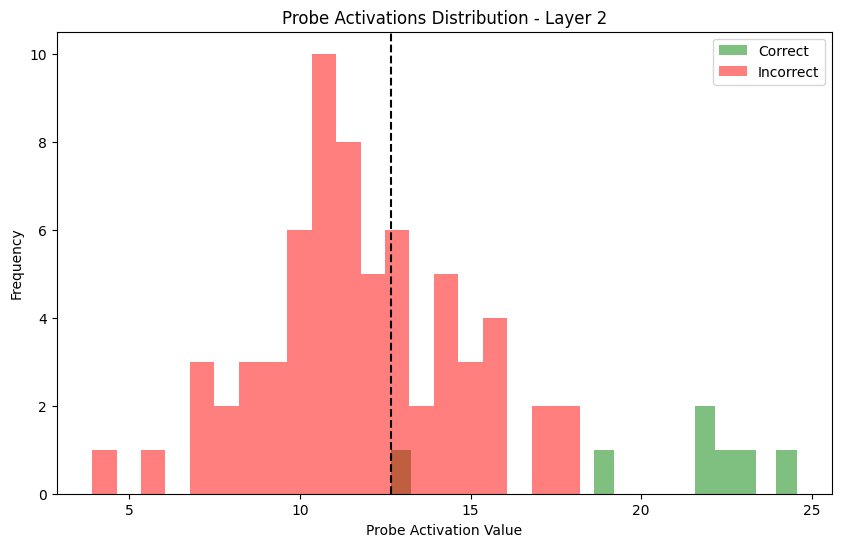

Layer 3


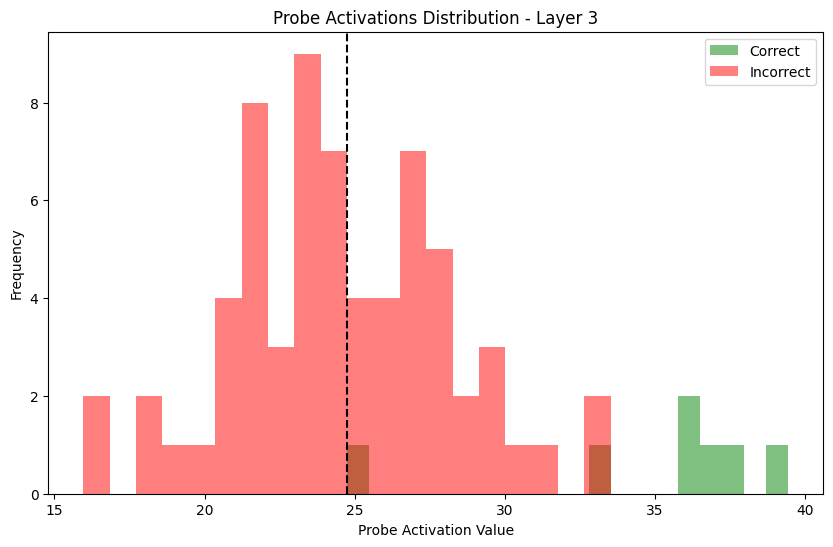

Layer 4


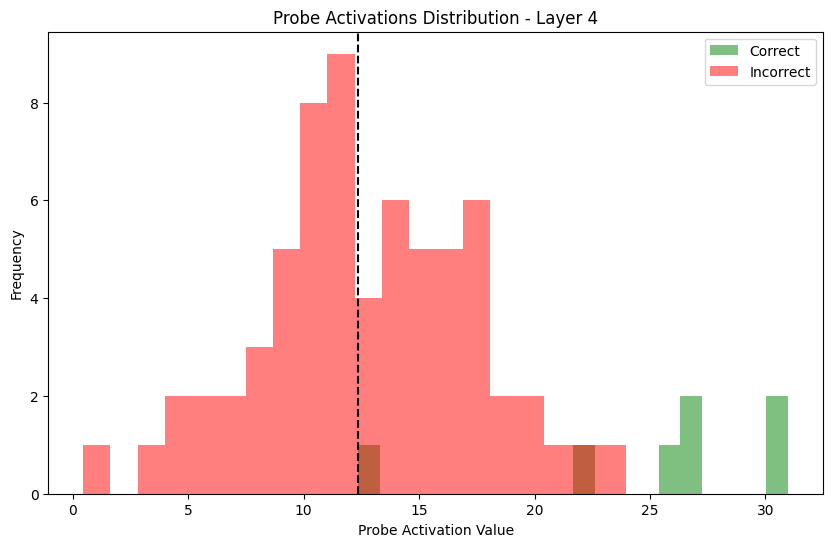

Layer 5


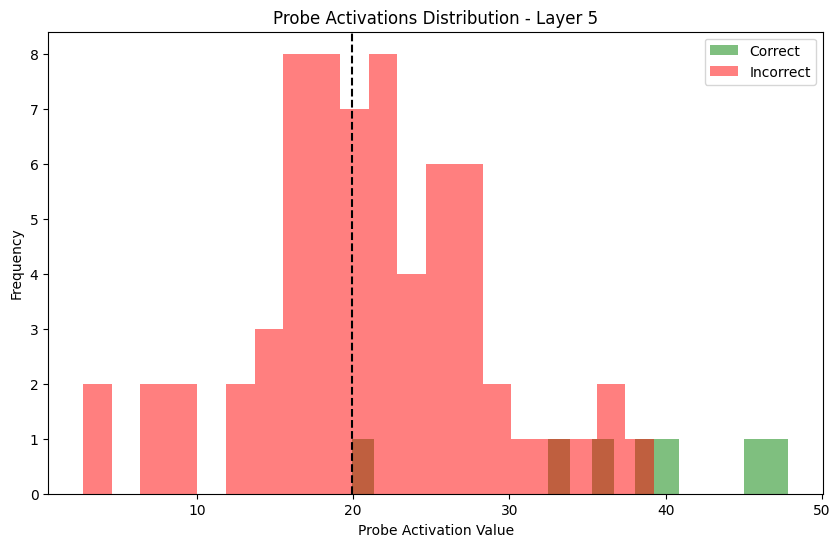

Layer 6


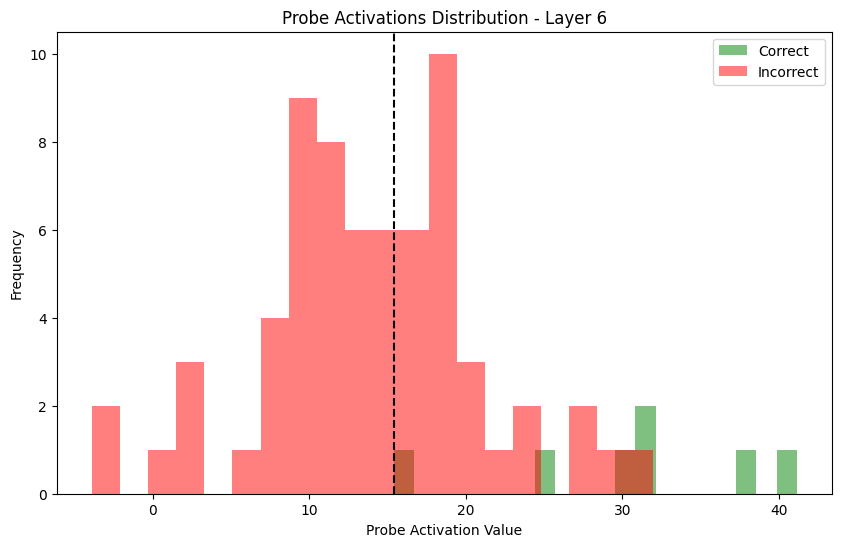

Layer 7


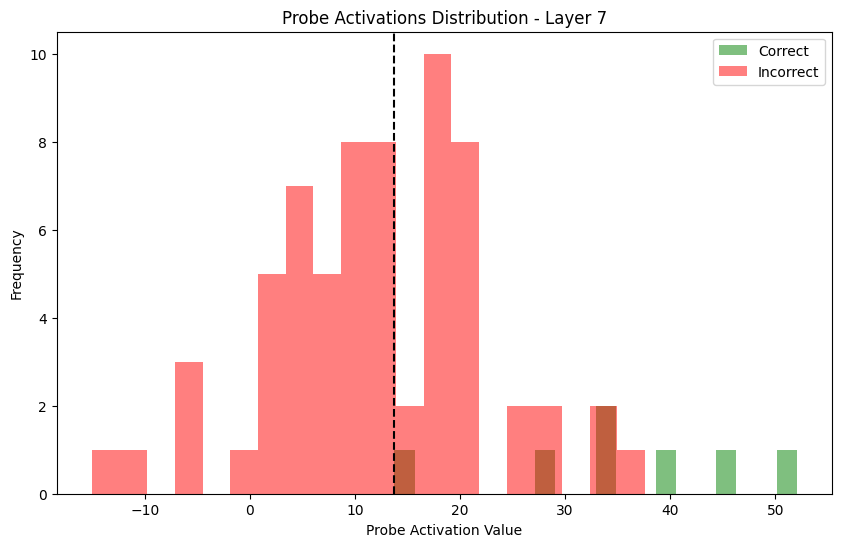

Layer 8


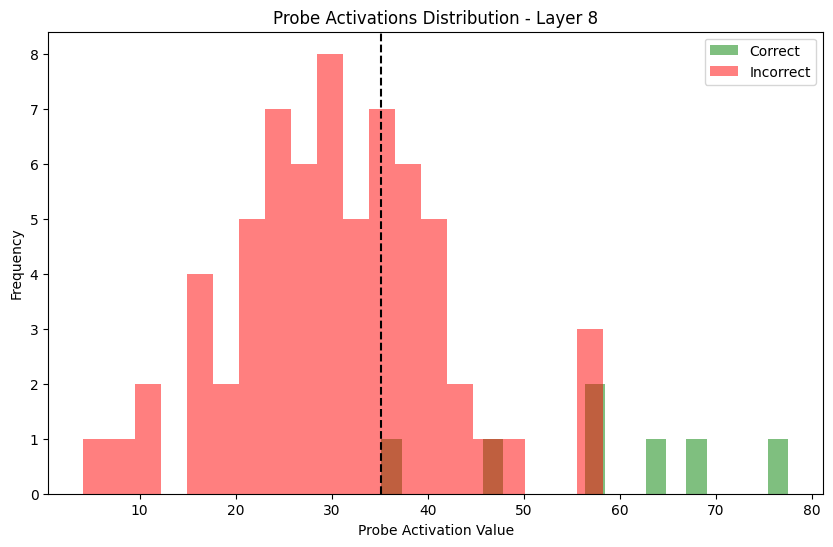

Layer 9


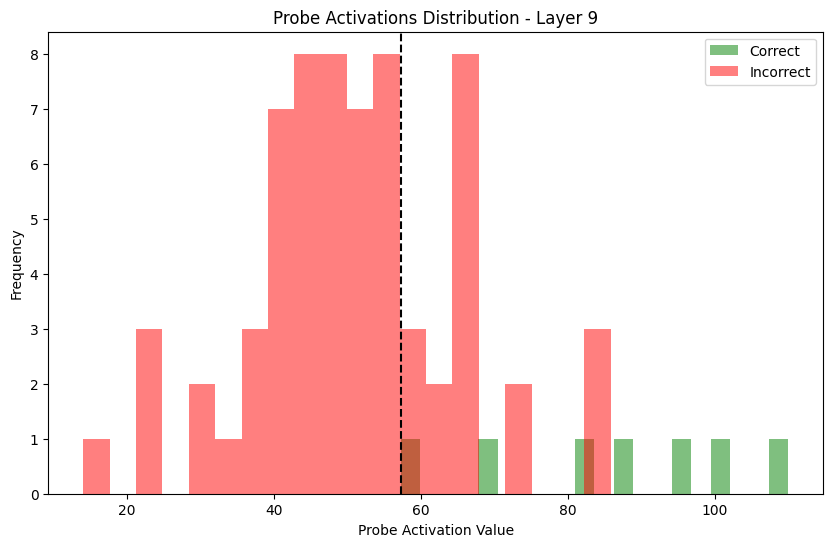

Layer 10


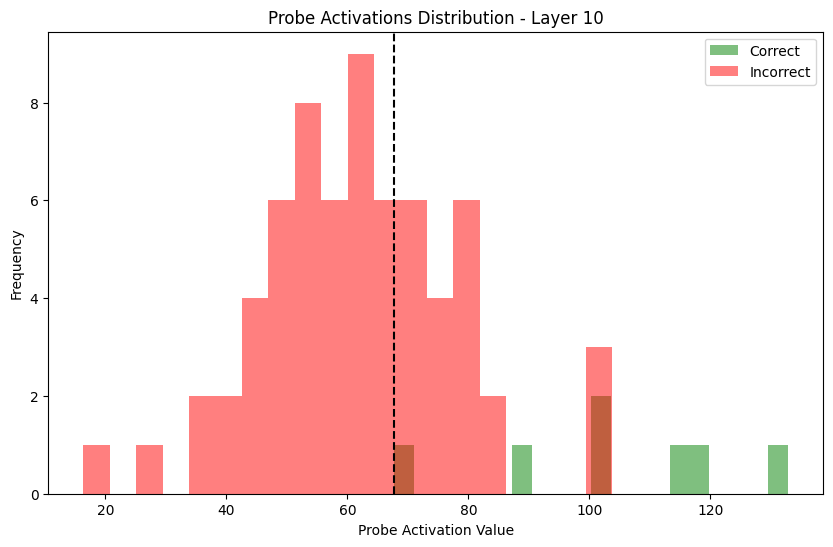

Layer 11


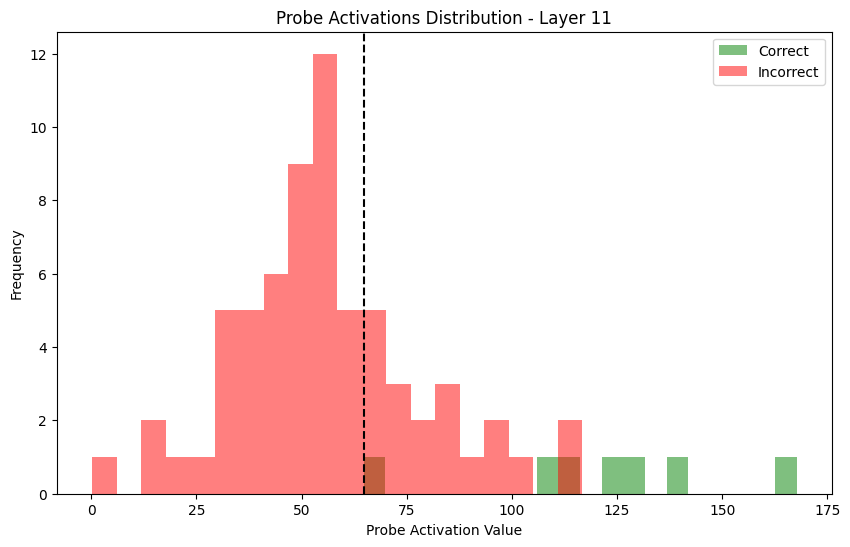

Layer 12


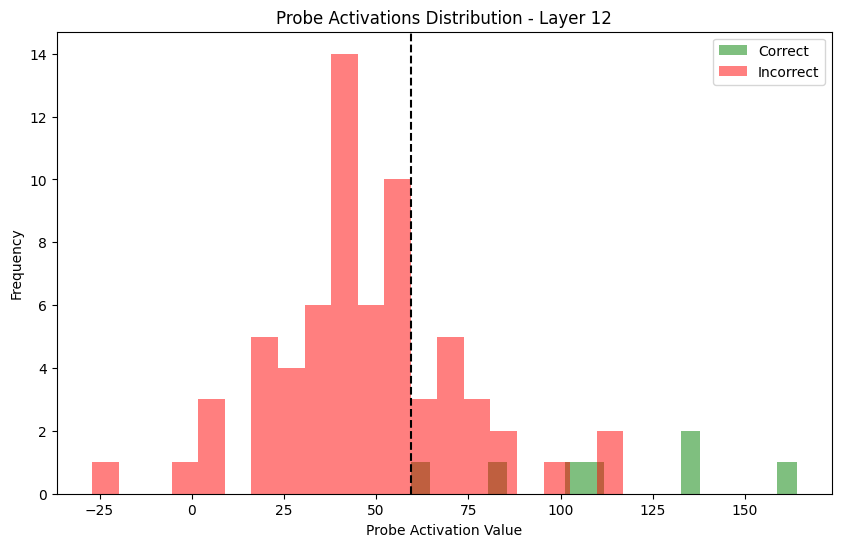

Layer 13


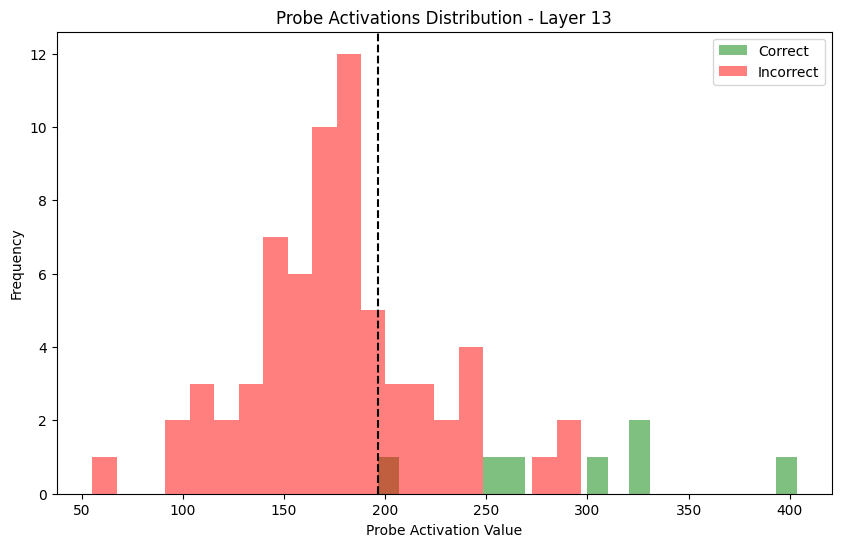

Layer 14


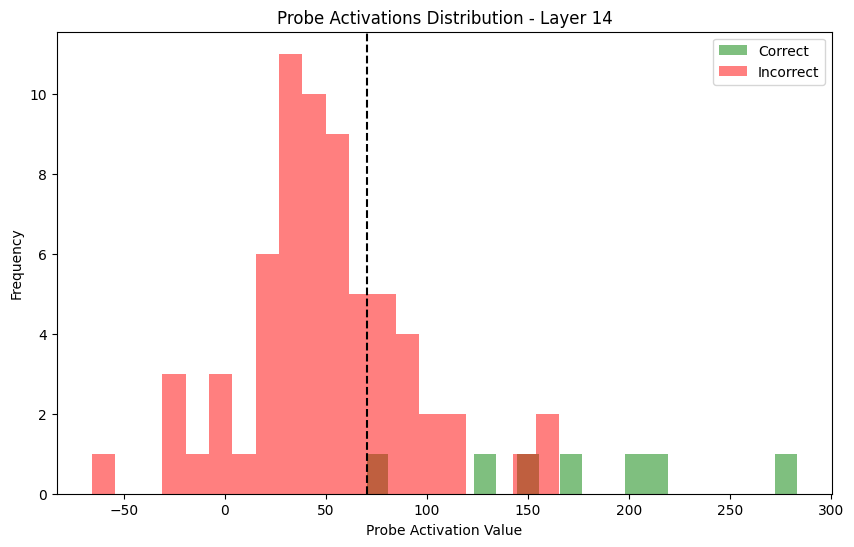

Layer 15


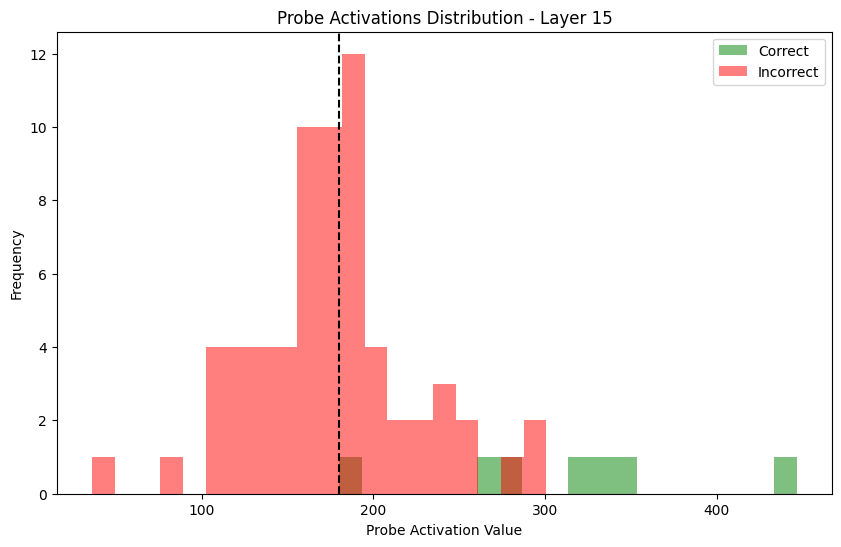

Layer 16


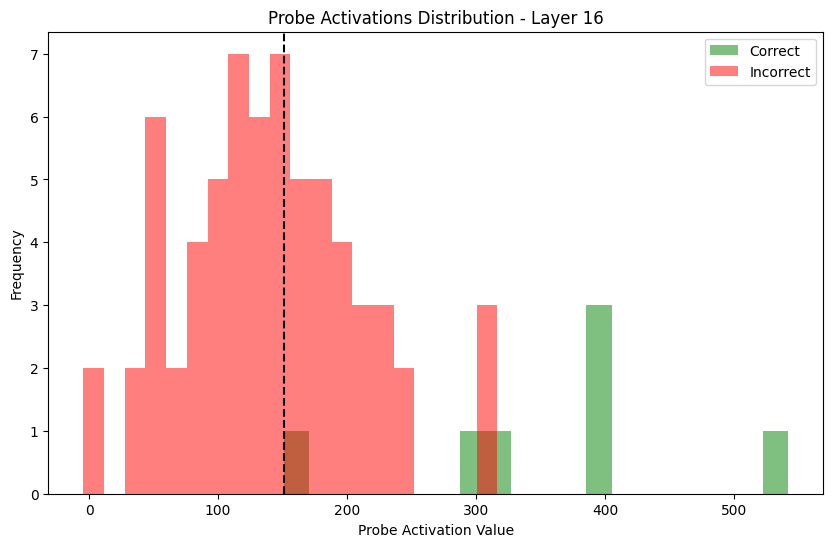

Layer 17


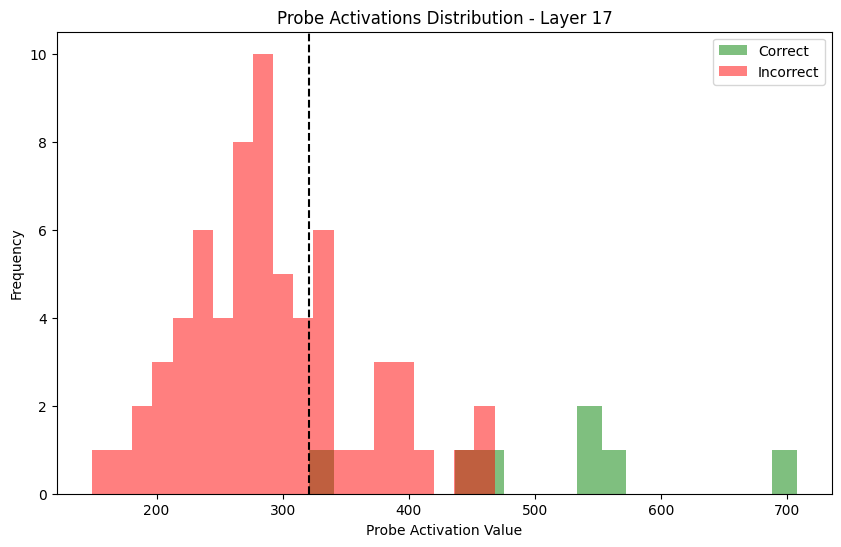

Layer 18


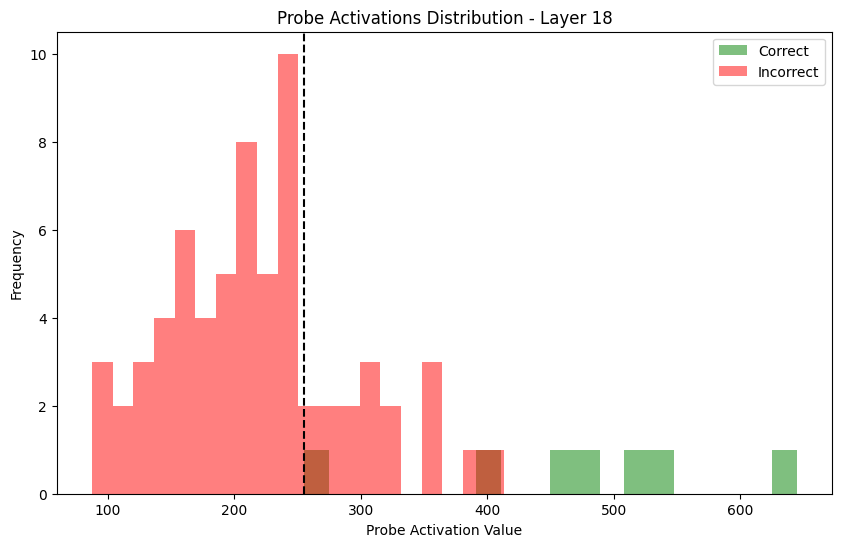

Layer 19


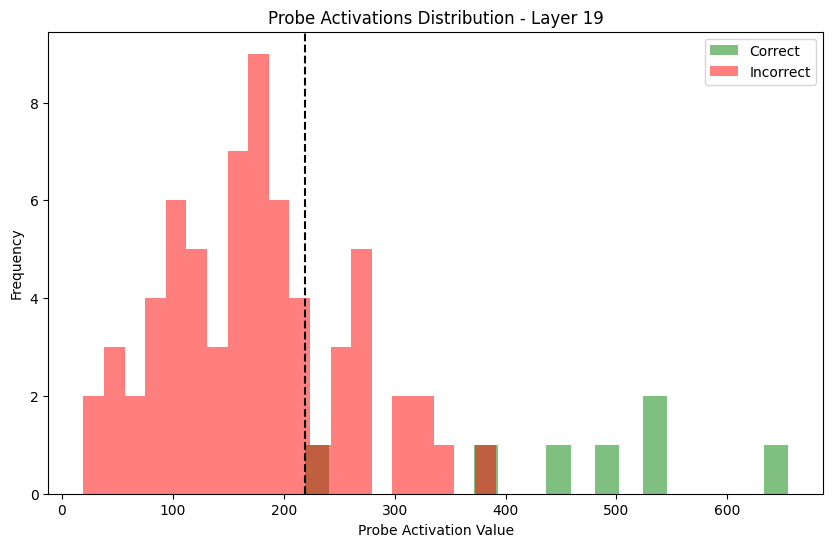

Layer 20


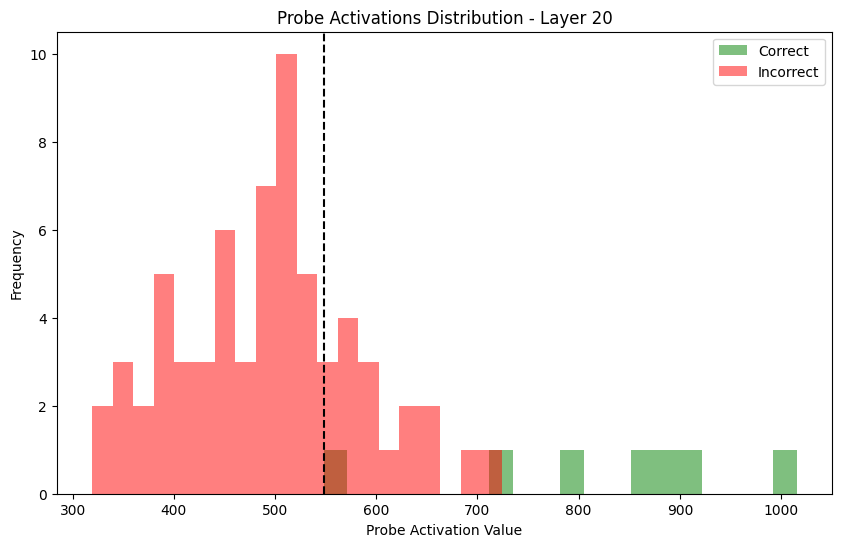

Layer 21


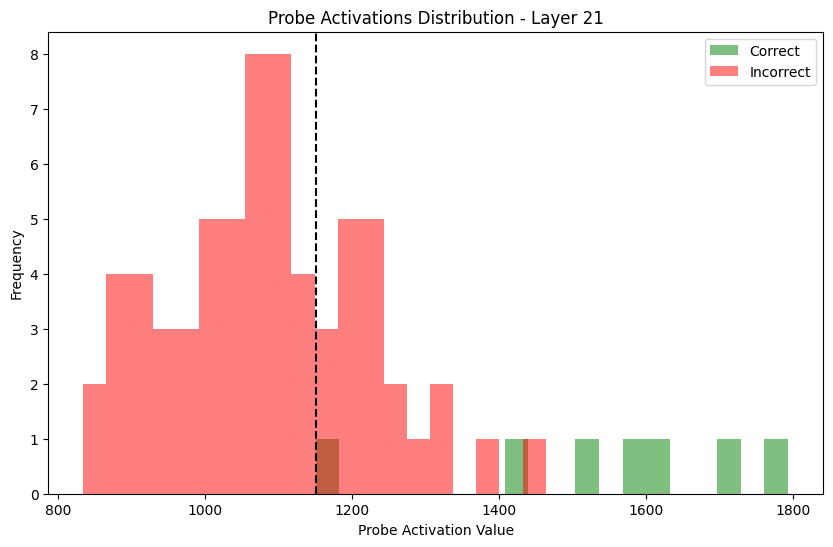

Layer 22


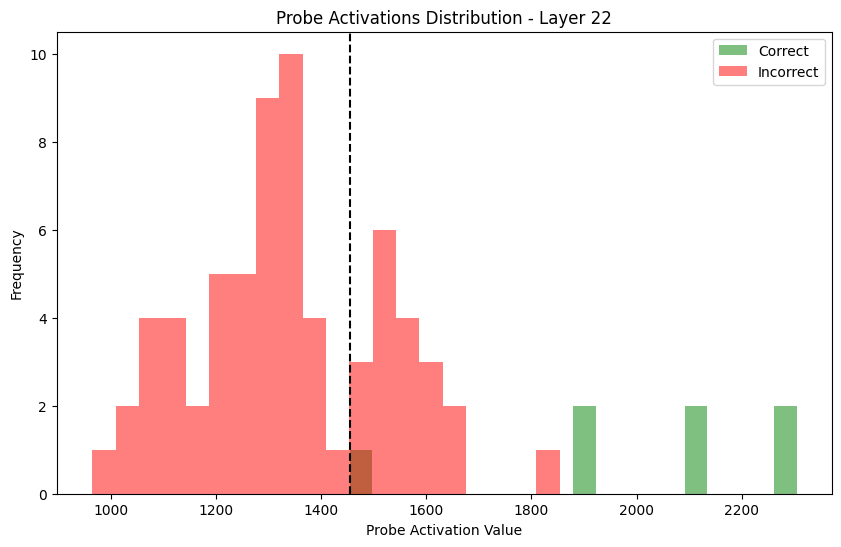

Layer 23


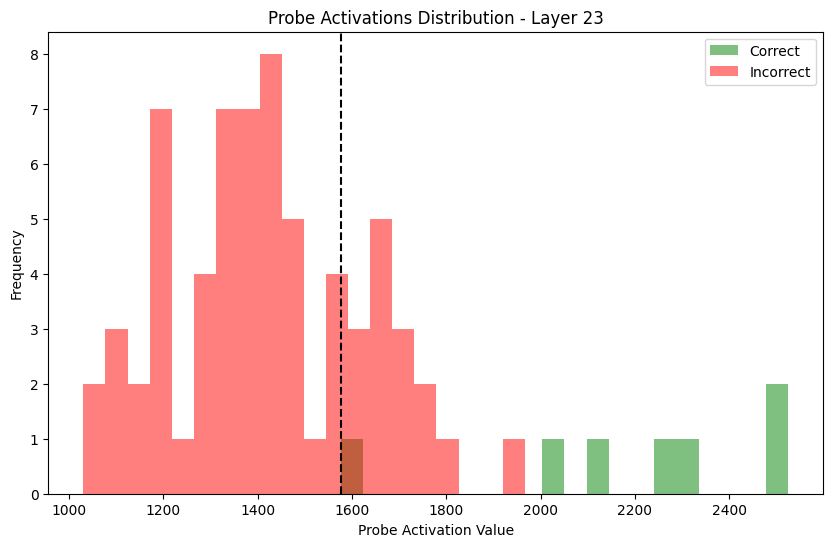

Layer 24


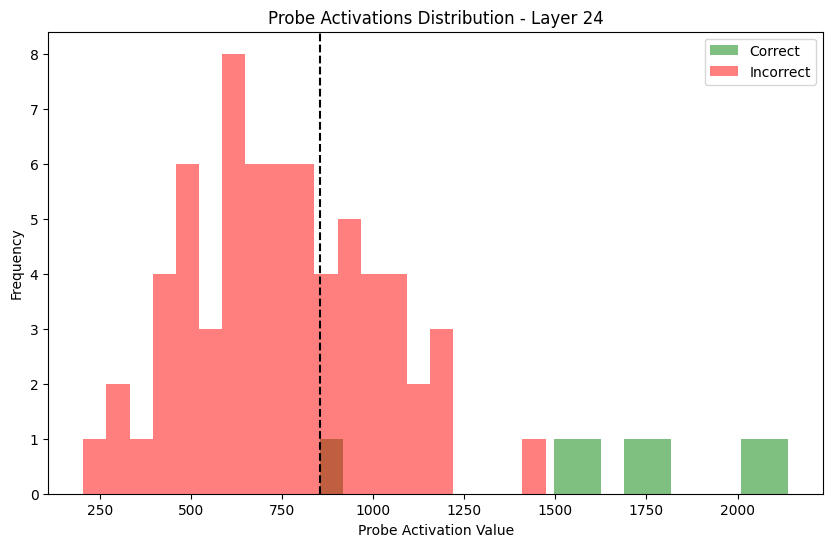

Layer 25


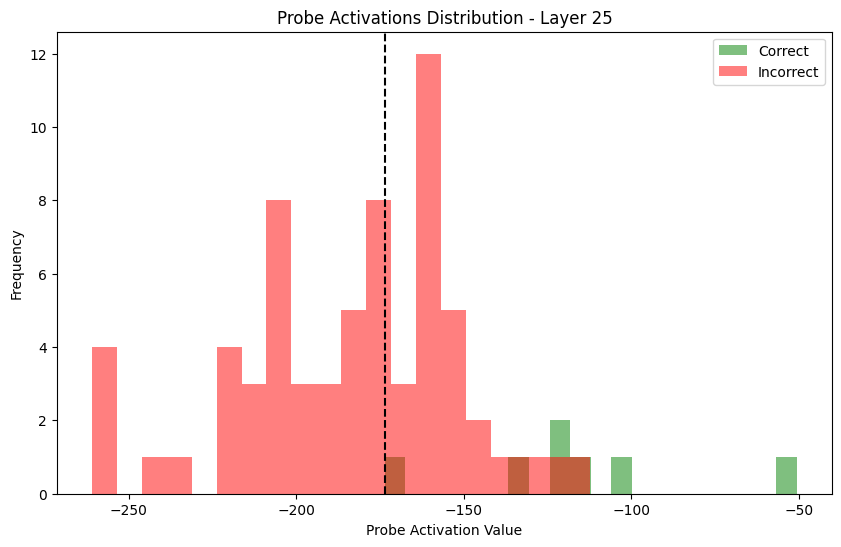

In [36]:
import matplotlib.pyplot as plt

mean_probe_acts_by_layer_by_q = [pa.mean(-1) for pa in probe_acts_by_layer_by_q]
# min_probe_acts_by_layer_by_q = [pa.min(-1) for pa in probe_acts_by_layer_by_q]
# max_probe_acts_by_layer_by_q = [pa.max(-1) for pa in probe_acts_by_layer_by_q]

for layer in activations.layers:
    print(f"Layer {layer}")
    probe_acts_by_q = [
        mean_probe_acts_by_layer_by_q[q_idx][layer].item()
        for q_idx in range(len(eval_results.questions))
    ]
    correct_probe_acts = [probe_acts_by_q[q_idx] for q_idx in correct_idxs]
    incorrect_probe_acts = [probe_acts_by_q[q_idx] for q_idx in incorrect_idxs]

    plt.figure(figsize=(10, 6))
    plt.hist(correct_probe_acts, bins=20, alpha=0.5, color="green", label="Correct")
    plt.hist(incorrect_probe_acts, bins=20, alpha=0.5, color="red", label="Incorrect")
    plt.axvline(x=correct_probe_acts[CORR_Q_LOO], color="black", linestyle="--")
    plt.title(f"Probe Activations Distribution - Layer {layer}")
    plt.xlabel("Probe Activation Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

In [22]:
def vis_q(q_idx: int, layers):
    probe_acts = probe_acts_by_layer_by_q[q_idx]
    print(f"Question {q_idx}")
    first_response_loc = eval_results.questions[q_idx].locs["response"][0]
    context_tokens = eval_results.questions[q_idx].tokens[
        first_response_loc - 100 : first_response_loc
    ]
    display(
        HTML(
            visualize_tokens_html(
                context_tokens, tokenizer, [0.0] * len(context_tokens)
            )
        )
    )
    for layer in layers:
        print(f"Layer {layer}")
        tokens = eval_results.questions[q_idx].tokens[first_response_loc:]
        values = probe_acts[layer].tolist()
        display(HTML(visualize_tokens_html(tokens, tokenizer, values)))


layers = list(range(12, 21))

In [23]:
vis_q(10, layers)

Question 10


Layer 12


Layer 13


Layer 14


Layer 15


Layer 16


Layer 17


Layer 18


Layer 19


Layer 20


In [62]:
vis_q(2, layers)

Question 2


Layer 12


Layer 13


Layer 14


Layer 15


Layer 16


Layer 17


Layer 18


Layer 19


Layer 20


In [63]:
vis_q(3, layers)

Question 3


Layer 12


Layer 13


Layer 14


Layer 15


Layer 16


Layer 17


Layer 18


Layer 19


Layer 20


In [64]:
vis_q(5, layers)

Question 5


Layer 12


Layer 13


Layer 14


Layer 15


Layer 16


Layer 17


Layer 18


Layer 19


Layer 20
